<a href="https://colab.research.google.com/github/Yousif-A2/Ai-diploma/blob/main/yousif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✈️ Flight Delay and Cancellation

---

Analysis

This notebook explores a dataset of U.S. flight delays and cancellations (2019–2023) to predict delays using machine learning with GPU acceleration.

## 📑 Table of Contents
1. [Setup](#setup)
2. [Data Loading](#data-loading)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Preprocessing](#preprocessing)
5. [Modeling](#modeling)
6. [Evaluation](#evaluation)

## 1. 🔧 Download Dataset

In [5]:
!mkdir -p ~/.kaggle

!cp /content/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download patrickzel/flight-delay-and-cancellation-dataset-2019-2023

# Unzip the downloaded file
!unzip flight-delay-and-cancellation-dataset-2019-2023.zip

# If you just want the specific CSV file mentioned in your link:
!kaggle datasets download patrickzel/flight-delay-and-cancellation-dataset-2019-2023 -f flights_sample_3m.csv

Dataset URL: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023
License(s): other
Archive:  flight-delay-and-cancellation-dataset-2019-2023.zip
  inflating: dictionary.html         
  inflating: flights_sample_3m.csv   
Dataset URL: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023
License(s): other


In [6]:
%load_ext cudf.pandas

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [35]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=9e58df9ee662bbfd9732f59ddd9e9e8be4359a372f8040c4d14685672bd0b6f5
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cuml
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
import seaborn as sns
import time
import GPUtil

## 2. 📥 Data Loading

In [8]:
import zipfile
with zipfile.ZipFile('/content/flight-delay-and-cancellation-dataset-2019-2023.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [9]:
%%cudf.pandas.profile

gdf = pd.read_csv('flights_sample_3m.csv')
#

# Display the first few rows
print("\nFirst 5 rows:")
gdf.head()


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.11/dist-packages/cudf/pandas/profiler.py", line 97, in __enter__
    sys.settrace(self._tracefunc)




First 5 rows:


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,<NA>,<NA>,<NA>,<NA>,<NA>
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,<NA>,<NA>,<NA>,<NA>,<NA>
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,<NA>,<NA>,<NA>,<NA>,<NA>
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,<NA>,<NA>,<NA>,<NA>,<NA>



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.11/dist-packages/cudf/pandas/profiler.py", line 116, in __exit__
    sys.settrace(self._oldtrace)



                                                                                                        
                                       Total time elapsed: 3.420 seconds                                
                                     6 GPU function calls in 1.946 seconds                              
                                     0 CPU function calls in 0.000 seconds                              
                                                                                                        
                                                     Stats                                              
                                                                                                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function           ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ read_csv           │ 1          │ 1.130       │ 1.130       │ 0          │ 0.000       │ 0.000       │
│ NDFrame.head       │ 1          │ 0.043       │ 0.043       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__repr__ │ 1          │ 0.769       │ 0.769       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__len__  │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DataFrame          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index.__len__      │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
└────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

## 3. 📊 Exploratory Data Analysis

Let's understand the structure, types, and initial insights from the dataset.

In [10]:
gdf.shape

(3000000, 32)

In [11]:
%%cudf.pandas.profile

print("\nColumn names:")
gdf.columns.tolist()


Column names:


['FL_DATE',
 'AIRLINE',
 'AIRLINE_DOT',
 'AIRLINE_CODE',
 'DOT_CODE',
 'FL_NUMBER',
 'ORIGIN',
 'ORIGIN_CITY',
 'DEST',
 'DEST_CITY',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'CANCELLATION_CODE',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'DELAY_DUE_CARRIER',
 'DELAY_DUE_WEATHER',
 'DELAY_DUE_NAS',
 'DELAY_DUE_SECURITY',
 'DELAY_DUE_LATE_AIRCRAFT']

                                                                                                          
                                        Total time elapsed: 0.744 seconds                                 
                                      0 GPU function calls in 0.000 seconds                               
                                      1 CPU function calls in 0.005 seconds                               
                                                                                                          
                                                      Stats                                               
                                                                                                          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function             ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ IndexOpsMixin.tolist │ 0          │ 0.000       │ 0.000       │ 1          │ 0.005       │ 0.005       │
└──────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- IndexOpsMixin.tolist

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=861642;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [12]:
%%cudf.pandas.profile

print("\nData types:")
for col in gdf.columns:
    print(f"{col}: {gdf[col].dtype}")


Data types:
FL_DATE: object
AIRLINE: object
AIRLINE_DOT: object
AIRLINE_CODE: object
DOT_CODE: int64
FL_NUMBER: int64
ORIGIN: object
ORIGIN_CITY: object
DEST: object
DEST_CITY: object
CRS_DEP_TIME: int64
DEP_TIME: float64
DEP_DELAY: float64
TAXI_OUT: float64
WHEELS_OFF: float64
WHEELS_ON: float64
TAXI_IN: float64
CRS_ARR_TIME: int64
ARR_TIME: float64
ARR_DELAY: float64
CANCELLED: float64
CANCELLATION_CODE: object
DIVERTED: float64
CRS_ELAPSED_TIME: float64
ELAPSED_TIME: float64
AIR_TIME: float64
DISTANCE: float64
DELAY_DUE_CARRIER: float64
DELAY_DUE_WEATHER: float64
DELAY_DUE_NAS: float64
DELAY_DUE_SECURITY: float64
DELAY_DUE_LATE_AIRCRAFT: float64


                                                                                                           
                                         Total time elapsed: 0.679 seconds                                 
                                      32 GPU function calls in 0.093 seconds                               
                                       0 CPU function calls in 0.000 seconds                               
                                                                                                           
                                                       Stats                                               
                                                                                                           
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function              ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DataFrame.__getitem__ │ 32         │ 0.093       │ 0.003       │ 0          │ 0.000       │ 0.000       │
└───────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [13]:
%%cudf.pandas.profile

# Summary statistics
print("\nSummary statistics:")
gdf.describe()


Summary statistics:


,DOT_CODE,FL_NUMBER,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
count,3.000000e+06,3.000000e+06,3.000000e+06,2.922385e+06,2.922356e+06,2.921194e+06,2.921194e+06,2.920056e+06,2.920056e+06,3.000000e+06,...,3.000000e+06,2.999986e+06,2.913802e+06,2.913802e+06,3.000000e+06,533863.000000,533863.000000,533863.000000,533863.000000,533863.000000
mean,1.997629e+04,2.511536e+03,1.327062e+03,1.329776e+03,1.012333e+01,1.664305e+01,1.352361e+03,1.462500e+03,7.678982e+00,1.490561e+03,...,2.352000e-03,1.422758e+02,1.366205e+02,1.123108e+02,8.093616e+02,24.759086,3.985260,13.164728,0.145931,25.471282
std,3.772846e+02,1.747258e+03,4.858789e+02,4.993101e+02,4.925183e+01,9.192901e+00,5.008727e+02,5.272368e+02,6.269639e+00,5.115476e+02,...,4.844000e-02,7.155669e+01,7.167582e+01,6.975484e+01,5.878939e+02,71.771845,32.410796,33.161122,3.582053,55.766892
min,1.939300e+04,1.000000e+00,1.000000e+00,1.000000e+00,-9.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,1.000000e+00,1.500000e+01,8.000000e+00,2.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.979000e+04,1.051000e+03,9.150000e+02,9.160000e+02,-6.000000e+00,1.100000e+01,9.310000e+02,1.049000e+03,4.000000e+00,1.107000e+03,...,0.000000e+00,9.000000e+01,8.400000e+01,6.100000e+01,3.770000e+02,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.993000e+04,2.152000e+03,1.320000e+03,1.323000e+03,-2.000000e+00,1.400000e+01,1.336000e+03,1.501000e+03,6.000000e+00,1.516000e+03,...,0.000000e+00,1.250000e+02,1.200000e+02,9.500000e+01,6.510000e+02,4.000000,0.000000,0.000000,0.000000,0.000000
75%,2.036800e+04,3.797000e+03,1.730000e+03,1.739000e+03,6.000000e+00,1.900000e+01,1.752000e+03,1.908000e+03,9.000000e+00,1.919000e+03,...,0.000000e+00,1.720000e+02,1.670000e+02,1.420000e+02,1.046000e+03,23.000000,0.000000,17.000000,0.000000,30.000000
max,2.045200e+04,9.562000e+03,2.359000e+03,2.400000e+03,2.966000e+03,1.840000e+02,2.400000e+03,2.400000e+03,2.490000e+02,2.400000e+03,...,1.000000e+00,7.050000e+02,7.390000e+02,6.920000e+02,5.812000e+03,2934.000000,1653.000000,1741.000000,1185.000000,2557.000000


                                                                                                        
                                       Total time elapsed: 6.591 seconds                                
                                     4 GPU function calls in 5.331 seconds                              
                                     0 CPU function calls in 0.000 seconds                              
                                                                                                        
                                                     Stats                                              
                                                                                                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function           ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ NDFrame.describe   │ 1          │ 5.014       │ 5.014       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__repr__ │ 1          │ 0.314       │ 0.314       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__len__  │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index.__len__      │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
└────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [14]:
%%cudf.pandas.profile

#  Delay statistics by airline
if 'AIRLINE' in gdf.columns and 'ARR_DELAY' in gdf.columns:
    avg_delay_by_airline = gdf.groupby('AIRLINE')['ARR_DELAY'].mean().sort_values(ascending=False)
    print("\nAverage arrival delay by airline (minutes):")
    print(avg_delay_by_airline)


Average arrival delay by airline (minutes):
AIRLINE
Allegiant Air                         13.284601
JetBlue Airways                       12.276125
Frontier Airlines Inc.                11.100429
ExpressJet Airlines LLC d/b/a aha!    10.031976
Spirit Air Lines                       8.029485
Mesa Airlines Inc.                     7.309810
American Airlines Inc.                 6.661229
United Air Lines Inc.                  5.035985
SkyWest Airlines Inc.                  4.023311
PSA Airlines Inc.                      3.928655
Hawaiian Airlines Inc.                 3.894757
Envoy Air                              3.278914
Southwest Airlines Co.                 3.269796
Horizon Air                            2.376242
Alaska Airlines Inc.                   1.097900
Delta Air Lines Inc.                   1.085079
Republic Airline                       0.590176
Endeavor Air Inc.                     -1.258539
Name: ARR_DELAY, dtype: float64


                                                                                                                  
                                            Total time elapsed: 1.470 seconds                                     
                                          7 GPU function calls in 0.427 seconds                                   
                                          0 CPU function calls in 0.000 seconds                                   
                                                                                                                  
                                                          Stats                                                   
                                                                                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                     ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index.__contains__           │ 2          │ 0.151       │ 0.075       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.groupby            │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DataFrameGroupBy.__getitem__ │ 1          │ 0.015       │ 0.015       │ 0          │ 0.000       │ 0.000       │
│ GroupBy.mean                 │ 1          │ 0.200       │ 0.200       │ 0          │ 0.000       │ 0.000       │
│ Series.sort_values           │ 1          │ 0.038       │ 0.038       │ 0          │ 0.000       │ 0.000       │
│ object.__str__               │ 1          │ 0.022       │ 0.022       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

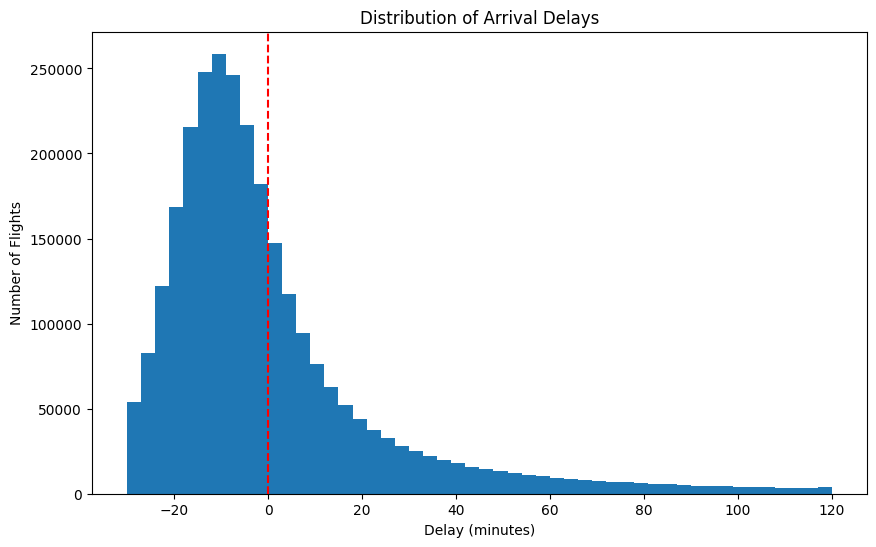

                                                                                                            
                                         Total time elapsed: 3.206 seconds                                  
                                       11 GPU function calls in 0.081 seconds                               
                                       0 CPU function calls in 0.000 seconds                                
                                                                                                            
                                                       Stats                                                
                                                                                                            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function               ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index.__contains__     │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__getitem__  │ 1          │ 0.009       │ 0.009       │ 0          │ 0.000       │ 0.000       │
│ Series.dropna          │ 1          │ 0.009       │ 0.009       │ 0          │ 0.000       │ 0.000       │
│ IndexOpsMixin.to_numpy │ 1          │ 0.026       │ 0.026       │ 0          │ 0.000       │ 0.000       │
│ ndarray                │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__len__        │ 2          │ 0.006       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__getitem__    │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.ravel          │ 1          │ 0.022       │ 0.022       │ 0          │ 0.000       │ 0.000       │
└────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [15]:
%%cudf.pandas.profile


# Sample visualization: Distribution of flight delays
if 'ARR_DELAY' in gdf.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(gdf['ARR_DELAY'].dropna(), bins=50, range=(-30, 120))
    plt.title('Distribution of Arrival Delays')
    plt.xlabel('Delay (minutes)')
    plt.ylabel('Number of Flights')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.show()

In [16]:
%%cudf.pandas.profile

if 'ARR_DELAY' in gdf.columns:
    mean_delay = gdf['ARR_DELAY'].mean()
    gdf['ARR_DELAY'].fillna(mean_delay, inplace=True)

                                                                                                           
                                         Total time elapsed: 0.410 seconds                                 
                                       5 GPU function calls in 0.051 seconds                               
                                       0 CPU function calls in 0.000 seconds                               
                                                                                                           
                                                       Stats                                               
                                                                                                           
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function              ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index.__contains__    │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__getitem__ │ 2          │ 0.004       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Series.mean           │ 1          │ 0.017       │ 0.017       │ 0          │ 0.000       │ 0.000       │
│ NDFrame.fillna        │ 1          │ 0.022       │ 0.022       │ 0          │ 0.000       │ 0.000       │
└───────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [17]:
%%cudf.pandas.profile

gdf['is_delayed'] = (gdf['ARR_DELAY'] > 15).astype(int)
print(gdf['is_delayed'])

0          0
1          0
2          0
3          1
4          0
          ..
2999995    0
2999996    0
2999997    1
2999998    0
2999999    0
Name: is_delayed, Length: 3000000, dtype: int64


                                                                                                           
                                         Total time elapsed: 0.624 seconds                                 
                                       6 GPU function calls in 0.093 seconds                               
                                       0 CPU function calls in 0.000 seconds                               
                                                                                                           
                                                       Stats                                               
                                                                                                           
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function              ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DataFrame.__getitem__ │ 2          │ 0.011       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ OpsMixin.__gt__       │ 1          │ 0.028       │ 0.028       │ 0          │ 0.000       │ 0.000       │
│ NDFrame.astype        │ 1          │ 0.006       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__setitem__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ object.__str__        │ 1          │ 0.046       │ 0.046       │ 0          │ 0.000       │ 0.000       │
└───────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [18]:
null_counts = gdf.isnull().sum()
null_counts

,0
FL_DATE,0
AIRLINE,0
AIRLINE_DOT,0
AIRLINE_CODE,0
DOT_CODE,0
FL_NUMBER,0
ORIGIN,0
ORIGIN_CITY,0
DEST,0
DEST_CITY,0


## 4. 🧹 Preprocessing

# Important Features:

- AIRLINE or (AIRLINE_DOT, AIRLINE_CODE): Airline operational practices are
strong indicators of potential delays.
- ORIGIN and DEST: Airport conditions and traffic patterns influence delay likelihood.
- CRS_DEP_TIME and CRS_ARR_TIME: Scheduled times can reveal potential peak periods or resource constraints. Consider extracting the hour of the day for improved performance.
- DISTANCE: Longer flights are more susceptible to delays.

In [19]:
gdf_colmuns = gdf[['AIRLINE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE','is_delayed']]

In [20]:
gdf_colmuns.head()

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,is_delayed
0,United Air Lines Inc.,FLL,EWR,1155,1501,1065.0,0
1,Delta Air Lines Inc.,MSP,SEA,2120,2315,1399.0,0
2,United Air Lines Inc.,DEN,MSP,954,1252,680.0,0
3,Delta Air Lines Inc.,MSP,SFO,1609,1829,1589.0,1
4,Spirit Air Lines,MCO,DFW,1840,2041,985.0,0


In [21]:
null_counts = gdf_colmuns.isnull().sum()
null_counts

,0
AIRLINE,0
ORIGIN,0
DEST,0
CRS_DEP_TIME,0
CRS_ARR_TIME,0
DISTANCE,0
is_delayed,0


In [22]:
object_columns = gdf_colmuns.select_dtypes(include=['object']).columns

# Encode object columns using Label Encoding
for col in object_columns:
    gdf_colmuns[col] = pd.factorize(gdf_colmuns[col])[0]

print(gdf_colmuns.head())


   AIRLINE  ORIGIN  DEST  CRS_DEP_TIME  CRS_ARR_TIME  DISTANCE  is_delayed
0        0       0     0          1155          1501    1065.0           0
1        1       1     1          2120          2315    1399.0           0
2        0       2     2           954          1252     680.0           0
3        1       1     3          1609          1829    1589.0           1
4        2       3     4          1840          2041     985.0           0


In [23]:
%%cudf.pandas.profile

columns_to_scale = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the selected columns and transform them
gdf_colmuns[columns_to_scale] = scaler.fit_transform(gdf_colmuns[columns_to_scale])

# Print the scaled DataFrame
print(gdf_colmuns.head())


   AIRLINE  ORIGIN  DEST  CRS_DEP_TIME  CRS_ARR_TIME  DISTANCE  is_delayed
0        0       0     0      0.489398      0.625261  0.179146           0
1        1       1     1      0.898643      0.964569  0.236901           0
2        0       2     2      0.404156      0.521467  0.112571           0
3        1       1     3      0.681934      0.761984  0.269756           1
4        2       3     4      0.779898      0.850354  0.165312           0


                                                                                                              
                                          Total time elapsed: 2.544 seconds                                   
                                        19 GPU function calls in 0.064 seconds                                
                                        5 CPU function calls in 0.011 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DataFrame.__getitem__    │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DataFrame                │ 1          │ 0.000       │ 0.000       │ 1          │ 0.000       │ 0.000       │
│ Series.apply             │ 0          │ 0.000       │ 0.000       │ 2          │ 0.008       │ 0.004       │
│ Series.any               │ 2          │ 0.010       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ Series.__len__           │ 0          │ 0.000       │ 0.000       │ 2          │ 0.002       │ 0.001       │
│ is_bool_dtype            │ 6          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ is_extension_array_dtype │ 6          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__setitem__    │ 1          │ 0.030       │ 0.030       │ 0          │ 0.000       │ 0.000       │
│ NDFrame.head             │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ object.__str__           │ 1          │ 0.016       │ 0.016       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- DataFrame
- Series.apply
- Series.__len__

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=47273;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [24]:
gdf_colmuns_sample = gdf_colmuns.sample(n=1000000, random_state=42)
print(gdf_colmuns_sample.head())

         AIRLINE  ORIGIN  DEST  CRS_DEP_TIME  CRS_ARR_TIME  DISTANCE  \
862231         4      19    35      0.436387      0.473947  0.037697   
2499752        3      25    49      0.427905      0.431013  0.058620   
2510019        4      20   164      0.483036      0.545644  0.066402   
1917689        7      32    38      0.338846      0.463943  0.188829   
2660759       15      63    63      0.264631      0.300959  0.095452   

         is_delayed  
862231            1  
2499752           0  
2510019           0  
1917689           0  
2660759           0  


In [25]:
gdf_colmuns['is_delayed'].value_counts()

,count
is_delayed,
0,2484711
1,515289


# Separate the data based on 'is_delayed' with equal representation

In [26]:
%%cudf.pandas.profile

delayed_flights = gdf_colmuns[gdf_colmuns['is_delayed'] == 1]
not_delayed_flights = gdf_colmuns[gdf_colmuns['is_delayed'] == 0]

# Determine the smaller group size
min_size = min(len(delayed_flights), len(not_delayed_flights))

# Sample both groups to have an equal number of instances
delayed_flights_sampled = delayed_flights.sample(n=min_size, random_state=42)  # Use random_state for reproducibility
not_delayed_flights_sampled = not_delayed_flights.sample(n=min_size, random_state=42)

# Concatenate the balanced datasets
balanced_gdf = pd.concat([delayed_flights_sampled, not_delayed_flights_sampled])

# Shuffle the balanced dataset
balanced_gdf = balanced_gdf.sample(frac=1, random_state=42).reset_index(drop=True)

# Class distribution
print(balanced_gdf['is_delayed'].value_counts())

is_delayed
0    515289
1    515289
Name: count, dtype: int64


                                                                                                                
                                           Total time elapsed: 0.301 seconds                                    
                                         16 GPU function calls in 0.111 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DataFrame.__getitem__      │ 5          │ 0.016       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ OpsMixin.__eq__            │ 2          │ 0.033       │ 0.017       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__len__          │ 2          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ NDFrame.sample             │ 3          │ 0.030       │ 0.010       │ 0          │ 0.000       │ 0.000       │
│ concat                     │ 1          │ 0.009       │ 0.009       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.reset_index      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ IndexOpsMixin.value_counts │ 1          │ 0.017       │ 0.017       │ 0          │ 0.000       │ 0.000       │
│ object.__str__             │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [27]:
print(balanced_gdf.shape)
X = balanced_gdf.drop('is_delayed', axis=1)
y = balanced_gdf['is_delayed']

(1030578, 7)


## 5. 🤖 Modeling

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, tree_method='gpu_hist')

# Train the model
model.fit(X_train, y_train)

# Check if training happened on GPU
print(f"XGBoost trained on GPU: {model.get_booster().feature_names is not None}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:55:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost trained on GPU: True


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:55:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6030778784761979
              precision    recall  f1-score   support

           0       0.60      0.60      0.60    102957
           1       0.60      0.61      0.60    103159

    accuracy                           0.60    206116
   macro avg       0.60      0.60      0.60    206116
weighted avg       0.60      0.60      0.60    206116



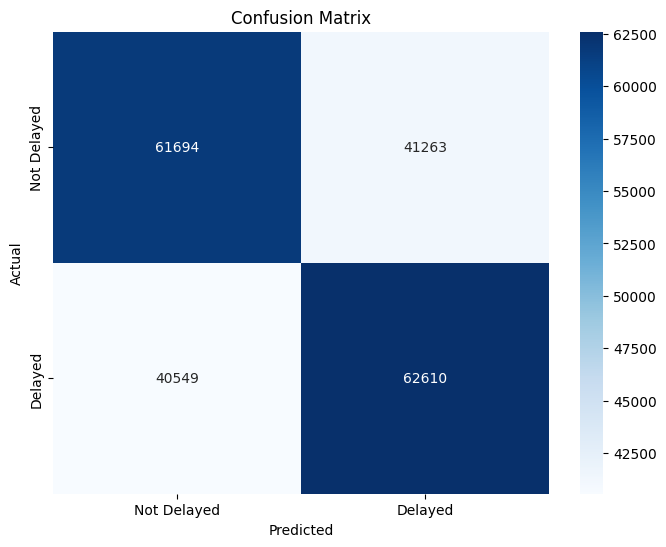

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Delayed', 'Delayed'],
            yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [37]:
# Import necessary libraries
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC

# Create and train different models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
    "SVC": SVC(random_state=42)
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")

    # Measure time
    start_time = time.time()

    # Measure GPU memory before training
    GPUs = GPUtil.getGPUs()
    before_memory = GPUs[0].memoryUsed

    model.fit(X_train, y_train)

    # Measure GPU memory after training
    after_memory = GPUs[0].memoryUsed

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    # Calculate time taken
    end_time = time.time()
    time_taken = end_time - start_time

    # Calculate memory used
    memory_used = after_memory - before_memory

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Time taken: {time_taken:.2f} seconds")
    print(f"{name} GPU memory used: {memory_used:.2f} MB")
    print(classification_report(y_test, y_pred))


[2025-04-20 16:14:48.800] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
Training RandomForest...
RandomForest Accuracy: 0.5985707077567971
RandomForest Time taken: 5.09 seconds
RandomForest GPU memory used: 0.00 MB
              precision    recall  f1-score   support

           0       0.61      0.57      0.58    102957
           1       0.59      0.63      0.61    103159

    accuracy                           0.60    206116
   macro avg       0.60      0.60      0.60    206116
weighted avg       0.60      0.60      0.60    206116

Training LogisticRegression...
LogisticRegression Accuracy: 0.5827980360573658
LogisticRegression Time taken: 0.99 seconds
LogisticRegression GPU memory used: 0.00 MB
              precision    recall  f1-score   support

           0       0.59      0.56      0.57    102957
           1       0.58      0.60      0.59    103159

    accuracy                           0.58    206116
   macro avg       0.58      

## 6. ✅ Evaluation

We evaluate model performance using a confusion matrix.

In [38]:
# Find the best model
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy {best_accuracy}")


Best Model: RandomForest with accuracy 0.5985707077567971
